Semi-supervised Community Detection using Graph Convolutional Network
=====================

Predicting community memberships of a network of entities is a common task in many real-world scenarios
working with graph data. In this tutorial, we demonstrate how to implement a Graph Convolutional Network (GCN)
[Kipf & Welling](https://arxiv.org/abs/1609.02907) using DGL to solve one such community detection problem in
a semi-supervised setting.

More specifically, you will learn:
- How to load graph data to DGLGraph?
- How to manipulate node/edge features on the graph?
- How to write a Graph Convolutional layer using message passing APIs?
- Train the model and visualize the result.

DGL is platform-agnostic and can support multiple popular tensor-based frameworks such as [PyTorch](https://pytorch.org) and [MXNet](https://mxnet.apache.org/). In this tutorial, we use MXNet/Gluon backend and provide equivalent Pytorch-based implementation in the comments.

In [1]:
# A bit of setup, just ignore this cell
import matplotlib.pyplot as plt

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['animation.html'] = 'html5'

Zachery's Karate Club
---
We start by creating the well-known *"Zachary's karate club"* social network. The network captures 34 members of a karate club, documenting pairwise links between members who interacted outside the club. The club later splits into two communities led by the instructor (node 0) and club president (node 33). You could read more about the story in the [wiki page](https://en.wikipedia.org/wiki/Zachary%27s_karate_club) A visualization of the network and the community is as follows:

![karate](https://www.dropbox.com/s/uqzor4lqsmbnz8k/karate1.jpg?dl=1)

Load graph data
---
Let's see how we can load such graph to DGL. We start with importing `dgl` and other relevant packages.

In [3]:
import dgl
dgl.load_backend('mxnet')

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

To create a graph in dgl, use `g = dgl.DGLGraph(graph_data)`. We support a wide range of `graph_data`. Here are some examples:

* An edge list (e.g. `[(0, 1), (1, 2), ...]`)
* A [`networkx`](https://networkx.github.io/) graph object.
* A scipy sparse matrix.

Since `networkx` already provides an API to create a karate club network, we can create a DGLGraph from it.

In [4]:
import networkx as nx

G = dgl.DGLGraph(nx.karate_club_graph())

Let's print out how many nodes and edges are there in this graph.

In [5]:
print('#Nodes', G.number_of_nodes())
print('#Edges', G.number_of_edges())

#Nodes 34
#Edges 156


DGLGraph can be converted to `networkx` very easily. For example, we can utilize `networkx` to visualize the graph:

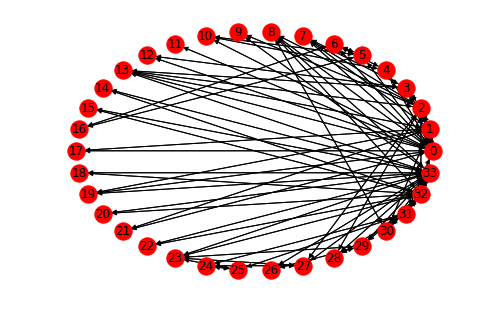

In [6]:
nx_G = G.to_networkx()
pos = nx.circular_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True)

Manipulating node/edge data
---

Nodes and edges in `DGLGraph` can have feature tensors. Features of multiple nodes/edges are batched on the first dimension. Let's start by assigning a random feature vector of length 5 to all nodes.

In [9]:
import mxnet as mx
import mxnet.ndarray as nd

G.ndata['feat'] = nd.random.randn(34, 5)

#>>> for torch users
# G.ndata['feat'] = torch.randn((34, 5))
#<<<

Now each node has a feature vector `'feat'` that has 5 elements. Note since there are 34 nodes in this graph, the first dimension must be of size 34, so that each row corresponds to the feature vector of each node. Error will be raised if the dimension mismatches:

In [11]:
# This will raise error!!
# G.ndata['wrong_feat'] = nd.random.randn(35, 5)

#>>> for torch users
# G.ndata['wrong_feat'] = torch.randn((35, 5))
#<<<

The `G.ndata` is a dictionary-like structure, so it is compatible with any operation on dictionary.

In [11]:
# Use `dict.update` to add new features (vector of length 3)
G.ndata.update({'another_feat' : nd.random.randn(34, 3)})
#>>> for torch users
# G.ndata.update({'another_feat' : torch.randn((34, 3))})
#<<<

# Print the feature dictionary
print(G.ndata)

# Delete the new feature
del G.ndata['another_feat']

{'feat': 
[[ 2.2122064   0.7740038   1.0434403   1.1839255   1.8917114 ]
 [-1.2347414  -1.771029   -0.45138445  0.57938355 -1.856082  ]
 [-1.9768796  -0.20801921  0.2444218  -0.03716067 -0.48774993]
 [-0.02261727  0.57461417  1.4661262   0.6862904   0.35496104]
 [ 1.0731696   0.12017461 -0.9711102  -0.77569664 -0.7882176 ]
 [ 0.7417728  -1.4734439  -1.0730928  -1.0424827  -1.3278849 ]
 [-1.4749662  -0.52414197  1.2662556   0.8950642  -0.6015945 ]
 [ 1.2040559  -0.9712193  -0.58256227  0.3717077   0.9300072 ]
 [-1.4225755  -0.5176199   2.0088325   0.2863085   0.5604595 ]
 [ 0.96975976 -0.52853745 -1.88909     0.65479124 -0.45481315]
 [ 0.32510808 -1.3002341   0.3679345   1.4534262   0.24154152]
 [ 0.47898006  0.96885103  0.30639967 -0.42438623 -0.20454668]
 [-0.42873764  1.3054723   0.64747655  1.1942346  -1.7404737 ]
 [ 0.26071024 -0.26782584 -0.31403625  0.03365511  0.61478573]
 [-1.1917231  -1.9933461   0.6015226   0.6394073  -0.6030918 ]
 [ 0.1832741   0.3553293   0.19826457  1.7928

Similar to `G.ndata` and `G.nodes`, we have `G.edata` and `G.edges` to access and modify edge features:

In [12]:
# The broness edge feature is just a scalar.
G.edata['broness'] = nd.ones((G.number_of_edges(),))
#>>> for torch users
# G.edata['broness'] = torch.ones((G.number_of_edges(),))
#<<<

# Use G.edges[src, dst] syntax to read/write features of specific edges.
# The instructor (node 0) is a tough guy, so his friends are a little bit scared of him.
G.edges[G.predecessors(0), 0].data['broness'] *= 0.5

print(G.edata)

{'broness': 
[1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.5 1.
 1.  1.  1.  1.  1.  1.  1.  0.5 1.  1.  1.  1.  1.  1.  1.  1.  1.  0.5
 1.  1.  1.  1.  1.  0.5 1.  1.  0.5 1.  1.  1.  0.5 1.  1.  1.  0.5 1.
 1.  1.  0.5 1.  1.  1.  1.  1.  1.  0.5 1.  1.  0.5 0.5 1.  0.5 1.  1.
 1.  1.  1.  1.  1.  1.  1.  1.  0.5 1.  1.  1.  0.5 1.  1.  1.  1.  0.5
 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.5 1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. ]
<NDArray 156 @cpu(0)>}


Define a GCN layer using message passing paradigm
---

Graph convolutional network (GCN) is a popular model proposed by [Kipf & Welling](https://arxiv.org/abs/1609.02907) to encode graph structure. The model consists of several layers, each perform convolution-like operation defined on graph:

$$
Y=\hat{A}XW
$$

, where $X$ is the node embedding tensor (stacked along the first dimension), $W$ is a projection matrix (the model parameter) and $\hat{A}$ is the normalized adjacency matrix:

$$
\hat{A} = D^{-\frac{1}{2}}AD^{-\frac{1}{2}}
$$

The computation can be expressed in terms of **message passing paradigm**:
* Each node first computes and sends out messages via its out-going edges.
* Each node then collects in-coming messages, aggregates them and update its own embedding.

Suppose the current embedding of node $i$ is $h_i^{(t)}$. A Graph Convolution operation can be rewritten as:

$$
\text{message phase: }m_{j\rightarrow i}=h_j^{(t)}W^{(t)}
$$

$$
\text{reduce phase: }\tilde{h}_i=\sum_{j\in\mathcal{N}(i)}\frac{1}{\sqrt{d_id_j}}m_{j\rightarrow i}
$$

TODO: a figure here

The above message passing computation can be easily implememented in DGL (omitting the normalization constant for simplicity):

In [13]:
import dgl.function as fn

message_func = fn.copy_src('h', 'm')
reduce_func = fn.sum('m', 'h')

We then use the message function and reduce function to define a `GraphConv` module. (Example uses pytorch's nn module. One can also use `mxnet.gluon.Block`).

In [14]:
import mxnet.gluon as gluon
import mxnet.gluon.nn as nn

# Define the GraphConv module
class GraphConv(gluon.Block):
    def __init__(self, in_feats, out_feats):
        super(GraphConv, self).__init__()
        self.linear = nn.Dense(out_feats)
    
    def forward(self, g, inputs):
        # g is the graph and the inputs is the input node features
        # first perform linear transformation
        h = self.linear(inputs)
        # set the node features
        g.ndata['h'] = h
        # trigger message passing, using the defined message_func and reduce_func.
        g.update_all(message_func, reduce_func)
        # get the result node features
        return g.ndata.pop('h')

In [ ]:
#>>> for torch users
#import torch.nn as nn
#import torch.nn.functional as F

## Define the GraphConv module
#class GraphConv(nn.Module):
#    def __init__(self, in_feats, out_feats):
#        super(GraphConv, self).__init__()
#        self.linear = nn.Linear(in_feats, out_feats)
#    
#    def forward(self, g, inputs):
#        # g is the graph and the inputs is the input node features
#        # first perform linear transformation
#        h = self.linear(inputs)
#        # set the node features
#        g.ndata['h'] = h
#        # trigger message passing, using the defined message_func and reduce_func.
#        g.send(g.edges(), message_func)
#        g.recv(g.nodes(), reduce_func)
#        # get the result node features
#        h = g.ndata.pop('h')
#        return h
#<<<

We then define a two-layer Graph Convolutional Network using the above module.

In [15]:
# Define a 2-layer GCN model
class GCN(gluon.Block):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_size)
        self.conv2 = GraphConv(hidden_size, num_classes)
    
    def forward(self, g, inputs):
        h = self.conv1(g, inputs)
        h = nd.relu(h)
        h = self.conv2(g, h)
        return h

Now let's train this model to predict the the club membership after the split. To train the model, we adopt Kipf's semi-supervised setting:
* Only the instructor node (node 0) and the president node (node 33) are labeled.
* The initial node feature is a one-hot encoding of the node id.

In [25]:
from mxnet import autograd

inputs = nd.eye(34)  # featureless inputs
labeled_nodes = nd.array([0, 33])  # only the instructor and the president nodes are labeled
labels = nd.array([0, 1])  # their labels are different
net = GCN(34, 5, 2)
net.initialize()
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': 0.001})
loss_fn = gluon.loss.SoftmaxCELoss()

all_logits = []
for epoch in range(30):
    with autograd.record():
        logits = net(G, inputs)
        # we only compute loss for node 0 and node 33
        loss = loss_fn(logits[labeled_nodes], labels).sum()
    all_logits.append(logits.detach())
    
    loss.backward()
    trainer.step(batch_size=1)
    
    print('Epoch %d | Loss: %.4f' % (epoch, loss.asscalar()))

Epoch 0 | Loss: 1.4078
Epoch 1 | Loss: 1.3999
Epoch 2 | Loss: 1.3925
Epoch 3 | Loss: 1.3850
Epoch 4 | Loss: 1.3769
Epoch 5 | Loss: 1.3686
Epoch 6 | Loss: 1.3599
Epoch 7 | Loss: 1.3507
Epoch 8 | Loss: 1.3414
Epoch 9 | Loss: 1.3317
Epoch 10 | Loss: 1.3214
Epoch 11 | Loss: 1.3108
Epoch 12 | Loss: 1.2999
Epoch 13 | Loss: 1.2887
Epoch 14 | Loss: 1.2766
Epoch 15 | Loss: 1.2641
Epoch 16 | Loss: 1.2506
Epoch 17 | Loss: 1.2365
Epoch 18 | Loss: 1.2217
Epoch 19 | Loss: 1.2060
Epoch 20 | Loss: 1.1897
Epoch 21 | Loss: 1.1728
Epoch 22 | Loss: 1.1554
Epoch 23 | Loss: 1.1372
Epoch 24 | Loss: 1.1183
Epoch 25 | Loss: 1.0989
Epoch 26 | Loss: 1.0790
Epoch 27 | Loss: 1.0586
Epoch 28 | Loss: 1.0379
Epoch 29 | Loss: 1.0168


In [22]:
#>>> for torch users
#inputs = torch.eye(34)  # featureless inputs
#labeled_nodes = torch.tensor([0, 33])  # only the instructor and the president nodes are labeled
#labels = torch.tensor([0, 1])  # their labels are different
#net = GCN(34, 5, 2)
#optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
#
#all_logits = []
#for epoch in range(30):
#    logits = net(G, inputs)
#    all_logits.append(logits.detach())
#    logp = F.log_softmax(logits, 1)
#    # we only compute loss for node 0 and node 33
#    loss = F.nll_loss(logp[labeled_nodes], labels)
#
#    optimizer.zero_grad()
#    loss.backward()
#    optimizer.step()
#
#    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))
#<<<

Now let's visualize the results. Since the final node embedding is a vector of length two (for predicting two classes), we can plot it as a point on a 2D plot and visualize how the final embeddings cluster towards each other.

/home/jermaine/.local/lib/python3.7/site-packages/networkx-2.2-py3.7.egg/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


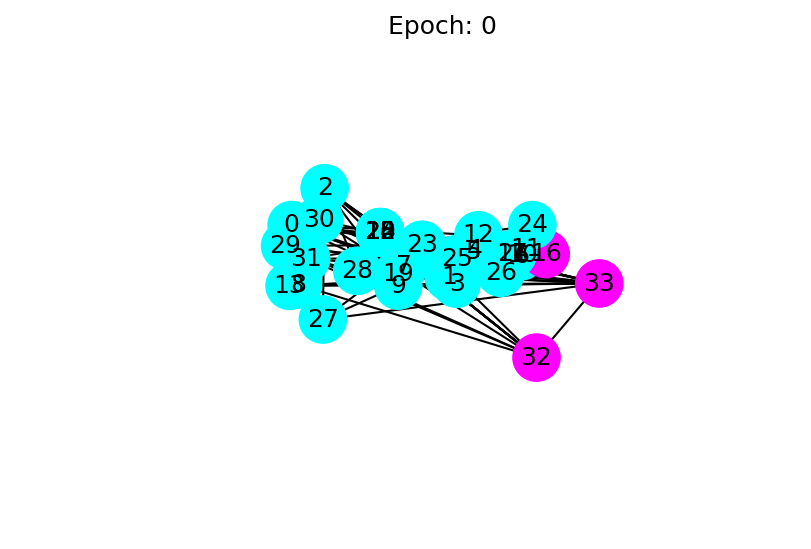

In [26]:
# Visualize the node classification using the logits output.
import numpy as np
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
nx_G = G.to_networkx()
def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(34):
        pos[v] = all_logits[i][v].asnumpy()
        cls = np.argmax(pos[v])
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw(nx_G.to_undirected(), pos, node_color=colors, with_labels=True, node_size=500)

ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=200)
HTML(ani.to_html5_video())

Advanced: writing arbitrary message and reduce function 
---

DGL provides many message and reduce functions to express different GNN variants. For instance, we support `src_mul_edge` as message function and `max` as reduce function. A full list of built-in message and reduce functions can be found [here](https://docs.dgl.ai/features/builtin.html).

However, there is always a chance to go beyond this list. In DGL, you can define arbitrary message and reduce function in python function:

In [29]:
# Same message function as `fn.copy_src`
def gcn_message_udf(edges):
    return {'m' : edges.src['h']}

# Same reduce function as `fn.sum`
def gcn_reduce_udf(nodes):
    return {'h' : nodes.mailbox['m'].sum(dim=1)}

The above functions perform the same computation as the built-in `copy_src` and `sum`. However, using DGL's built-in functions is much faster because we can map them to efficient CPU/GPU kernels while user-defined python functions can only be invoked in python side.